# imports

In [1]:
import os

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.pyplot.ion()
%matplotlib inline
import pickle

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.mds_qlpdb import QUBO_to_Ising, graph_summary

from qlp.tdse import TDSE, embed_qubo_example, convert_params, add_jchaos

from qlpdb.tdse.models import Tdse

import time

# Setup

## Graph specific parameters 

Creates a line graph `o-o-o-...-o`

In [2]:
nvertices = 2
graph, tag = gt.generate_nn_graph(nvertices)
directed = False

## ILP / QUBO setup

Initializes the Qubo for the Minimum Dominating Set problem

In [3]:
penalty = 2
qubo = get_mds_qubo(
    graph, directed=directed, penalty=penalty, triangularize=True, dtype="d"
)
qubo_constant = penalty * nvertices

## Set up ising model

Computes the corresponding Ising model parameters for the QUBO

**if embed is True:** 
    This embeds the QUBO into a chimera graph. Currently there is only an explicit result from G(2). I will in the future actually embed with DWave minorminer.

In [4]:
embed = True  # nvertices = [2, 3] available
jchaos = 0 #1/2**6

if embed:
    qubo, embedding = embed_qubo_example(nvertices)
    qubo = qubo/4 #rescale by hand to match manual rescaling of dwave

Jij_exact, hi_exact, c = QUBO_to_Ising(qubo.todense().tolist())

if embed:
    hi_for_offset = np.array(
        [
            hi_exact[key]
            for key in np.sort(list(embedding.keys()))
            for count in range(len(embedding[key]))
        ]
    )
else:
    hi_for_offset = hi_exact

Jij, hi = add_jchaos(Jij_exact, hi_exact, jchaos)

graph_params = graph_summary(tag, graph, qubo)
print(graph_params)

{'tag': 'NN(2)', 'total_vertices': 2, 'total_edges': 1, 'total_qubits': 5, 'max_edges': 1, 'adjacency': [[0, 1]], 'adjacency_hash': '2864ee150babb3f03de5e76a1733df4b'}


## Anneal specific parameters

Parameters which are related to converting physical unites to unitless units

* **annealing_time:** Annealing time as defined from s = [0, 1] in microseconds
* **normalized_time:** This is s. Set it to < 0 or > 1 if offset is used to allow for a complete annealing schedule. The total time in microseconds will increase accordingly.
* **energyscale:** Converts units from D-Wave parameters to unitless parameters (see eq. 65 in the notes)

In [5]:
annealing_time = 1

normalized_time = [0, 1]  # make larger range for complete offsets

# assume annealing_time unit in microsecond and energy unit in Ghz
def energyscaleconversion(annealing_time):
    return annealing_time * 1000.0 #*(2.0 * np.pi)


energyscale = energyscaleconversion(annealing_time)
ising_params = {
    "Jij": [list(row) for row in Jij],
    "hi": list(hi),
    "c": c,
    "Jij_exact": [list(row) for row in Jij_exact],
    "hi_exact": list(hi_exact),
    "energyscale": energyscale,
    "qubo_constant": qubo_constant,
    "penalty": penalty,
}
print(ising_params)

{'Jij': [[0.0, 0.0, 0.0, 0.5, -1.0], [0.0, 0.0, 0.0, -0.25, -0.25], [0.0, 0.0, 0.0, -0.25, -0.25], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0]], 'hi': [-0.1875, 0.25, 0.25, -0.375, -0.1875], 'c': 1.25, 'Jij_exact': [[0.0, 0.0, 0.0, 0.5, -1.0], [0.0, 0.0, 0.0, -0.25, -0.25], [0.0, 0.0, 0.0, -0.25, -0.25], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0]], 'hi_exact': [-0.1875, 0.25, 0.25, -0.375, -0.1875], 'energyscale': 1000.0, 'qubo_constant': 4, 'penalty': 2}


## Anneal curve specific parameters

Parameters which specify how the anneal curve is realized:

* **offset:** This is a string argument to the fcn method of the class AnnealOffset in qlp.mds.mds_qlpdb. Define your own anneal offset routine here or call
an existing one. E-mail me if you need more explanation.
* **offset_min, offset_range:** Argument to AnnealOffset class. Specify offset boundaries and are set later in a loop.
* **anneal_curve:** The realized curve. Currently implemented are linear, logistic and d-wave.
* **fill_value:** If normalized_time is extended beyond (0, 1), this option decides whether to extrapolate the anneal schedule, or truncate it at the nearest value.

In [6]:
offset = "binary"
anneal_curve = "dwave"
fill_value = "extrapolate"

## Parameters for numerical solve of ODE

Parameters to solve the ODE. See also `scipy.integrate.solve_ivp`.

In [7]:
solver_params = dict()
solver_params["method"] = "RK45"
solver_params["rtol"] = 4e-7
solver_params["atol"] = 4e-8

## System parameters

Parameters used to specify the initial conditions of the system:

* **pure_tdse:** This is a boolean (True / False) flag and runs the pure state solver.
* **mixed_tdse:** This boolean flag runs the mixed state solver.
* **temp:** This sets the temperature for the mixed state solver in kelvins.
* **initial_wavefunction:** For the pure state solver, the initial wavefunc- tion can be chosen to be the ground state of ∑σx (transverse) or H(0)(real). For the DWave anneal schedule, or when annealing offsets are used without extended annealing times, these two options are not the same. Can be "true" or "transverse".


In [8]:
initial_wavefunction = "transverse"

pure_tdse = False

mixed_tdse = True
temp = 0.05
gamma = 1/20

## Output parameters

Parameters used for visializing results:
* **degeneracy_tol:** This sets the numerical tolerance as to when an excited- state is labeled as degenerate to the ground state. This is important for graphs with degenerate ground states.
* **debug:** Write more output during computations.
* **save_result:** Store results to pickle files. 

In [9]:
degeneracy_tol = 2e-2
debug = True
save_result = True
skip_db = False

# Run computations

In this section we run over different anneal time offsets

offset -0.01
Init TDSE: 3.2133381366729736 seconds


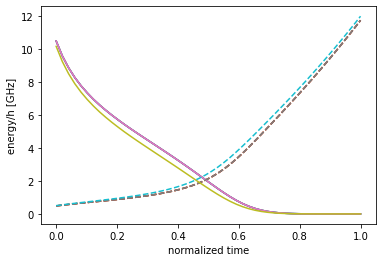

Ising ground state energy: -23.611301697885573
Ising ground state
29
11101
Ising ground state energy: -23.580957372919407
Ising ground state
14
01110
abcdeabcdf->ef
entropy param 1 abcdeabcdf->ef
mixed measurement not in db
dE [  0.          20.31953085  20.96514746  20.96514746  20.96514746
  20.96514746  41.2846783   41.2846783   41.2846783   41.2846783
  41.93029492  41.93029492  41.93029492  41.93029492  41.93029492
  41.93029492  62.24982576  62.24982576  62.24982576  62.24982576
  62.24982576  62.24982576  62.89544237  62.89544237  62.89544237
  62.89544237  83.21497322  83.21497322  83.21497322  83.21497322
  83.86058983 104.18012068]
pr [8.16055445e-01 3.66120071e-02 3.31734166e-02 3.31734166e-02
 3.31734166e-02 3.31734166e-02 1.48831231e-03 1.48831231e-03
 1.48831231e-03 1.48831231e-03 1.34853040e-03 1.34853040e-03
 1.34853040e-03 1.34853040e-03 1.34853040e-03 1.34853040e-03
 6.05012867e-05 6.05012867e-05 6.05012867e-05 6.05012867e-05
 6.05012867e-05 6.05012867e-05 5.48190212e

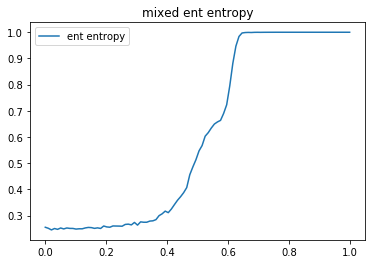

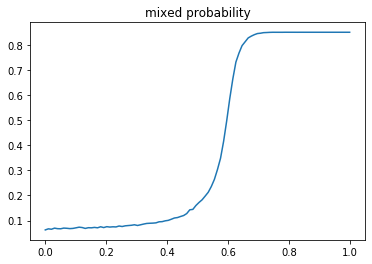

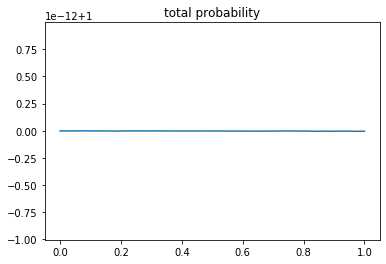

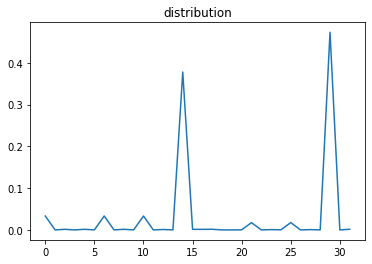

In [10]:
#%%timeit -n 1 -r 1

# brute force solving time-dependent schrodinger equation to simulate quantum annealing for small systems
result = dict()
offset_min_list = [-0.01]

for offset_min in offset_min_list:
    print("offset", offset_min)
    offset_min = offset_min
    offset_range = 2 * abs(offset_min)

    offset_params = {
        "annealing_time": annealing_time,
        "normalized_time": normalized_time,
        "offset": offset,
        "hi_for_offset": hi_for_offset,
        "offset_min": offset_min,
        "offset_range": offset_range,
        "fill_value": fill_value,
        "anneal_curve": anneal_curve,
    }

    # instantiate ode solver
    start = time.time()
    tdse = TDSE(graph_params, ising_params, offset_params, solver_params)
    end = time.time()
    print(f"Init TDSE: {end-start} seconds")
    
    # plot anneal schedule
    tdse.AS.plot(normalized_time)
    
    val,vec=np.linalg.eigh(tdse.IsingH.todense())
    print('Ising ground state energy:',val[0])
    print('Ising ground state')
    #print(vec[:,0])
    I=int(np.argmax(vec[:,0]))
    print(I)
    print('{0:05b}'.format(I))
    print('Ising ground state energy:',val[1])
    print('Ising ground state')
    #print(vec[:,1])
    I=int(np.argmax(vec[:,1]))
    print(I)
    print('{0:05b}'.format(I))
    
    # get offset list to get partition for entanglement entropy
    nA, indicesA = tdse.find_partition()
    print("entropy param",nA,indicesA)
    reg = 1e-10
    entropy_params = {"nA": nA, "indicesA": indicesA, "reg": reg}
    
    ############################################################
    ###### code block for thermal mixed state simultation ######
    ############################################################
    if mixed_tdse:
        wave_params = dict()
        wave_params["type"] = "mixed"
        wave_params["temp"] = temp
        wave_params["gamma"] = gamma
        wave_params["initial_wavefunction"] = initial_wavefunction
        if not skip_db:
            query = Tdse.objects.filter(
                graph__tag=graph_params["tag"],
                offset__contains=convert_params(offset_params),
                ising__contains=convert_params(ising_params),
                solver__contains=solver_params,
                wave__contains=wave_params,
            ).first()
        else:
            query = False
        if not query:
            print("mixed measurement not in db")
            # initial density matrix
            rho = tdse.init_densitymatrix(temp, initial_wavefunction, debug=debug)
            rhodim=int(np.sqrt(len(rho)))
            tdse.gamma=gamma
            print("Initial wavefunction:", rho)
            # solve
            start = time.time()
            sol_densitymatrix = tdse.solve_mixed(rho)
            end = time.time()
            print(f"von Neumann solve: {end-start} seconds")
            
            # overlap with Ising ground state
            gs_idx, Isingenergy, Isingeigv = tdse.ground_state_degeneracy(
                tdse.IsingH_exact, degeneracy_tol, debug=debug
            )
            project = sum(
                [
                    np.kron(Isingeigv[:, idx], np.conj(Isingeigv[:, idx]))
                    for idx in gs_idx
                ]
            )
            prob = np.asarray(
                [
                    np.absolute((np.dot(np.conj(project), sol_densitymatrix.y[:, i])))
                    for i in range(sol_densitymatrix.t.size)
                ]
            )
            totalprob = np.asarray(
                [
                    np.absolute((np.trace(sol_densitymatrix.y[:, i].reshape((rhodim,rhodim)))))
                    for i in range(sol_densitymatrix.t.size)
                ]
            )
            
            # save result to EspressoDB
            query = tdse.summary(
                wave_params=wave_params,
                instance=tdse,
                solution=sol_densitymatrix,
                time=sol_densitymatrix.t,
                probability=prob,
                save = save_result,
            )
        # calculate entanglement entropy
        # this example partion 4 qubits into A:(3,4) and B:(1,2)
        with open(query.solution.path, "rb") as file:
            sol = pickle.load(file)
        entropy = np.asarray(
            [
                tdse.ent_entropy(sol.y[:, i], **entropy_params)
                for i in range(sol.t.size)
            ]
        ).real
        # plot entropy
        plt.figure("mixed entropy")
        plt.plot(query.time, entropy)
        plt.legend(["ent entropy"])
        plt.title("mixed ent entropy")

        # plot overlap with Ising g.s.
        plt.figure("mixed prob")
        plt.plot(query.time, query.prob)
        plt.title("mixed probability")
        print(f"Mixed Final Prob: {query.prob[-1]}")
        
        # plot total probability.
        plt.figure("total prob")
        plt.plot(query.time, totalprob)
        plt.title("total probability")

        # check decoherence
        print("hi is",tdse.ising["hi"])
        finalstate=np.argmax(np.diagonal(sol_densitymatrix.y[:, -1].reshape((rhodim,rhodim))).real)
        print("final state",('{0:0'+str(len(tdse.ising["hi"]))+'b}').format(finalstate))
        
        # check distribution
        plt.figure("distribution")
        plt.plot(np.linspace(0,rhodim-1,rhodim), np.diagonal(sol_densitymatrix.y[:, -1].reshape((rhodim,rhodim))).real)
        plt.title("distribution")
    ############################################################
    ###### end of code block for thermal mixed state simultation ######
    ############################################################

    if pure_tdse:
        wave_params = dict()
        wave_params["type"] = "pure"
        wave_params["temp"] = 0
        wave_params["gamma"] = 0
        wave_params["initial_wavefunction"] = initial_wavefunction
        if not skip_db:
            query = Tdse.objects.filter(
                graph__tag=graph_params["tag"],
                offset__contains=convert_params(offset_params),
                ising__contains=convert_params(ising_params),
                solver__contains=solver_params,
                wave__contains=wave_params,
            ).first()
        else:
            query = False
        
        if not query:
            print("pure measurement not in db")
            # Initial wavefunction
            y1 = tdse.init_wavefunction(initial_wavefunction)
    
            # solve
            start = time.time()
            sol = tdse.solve_pure(y1, ngrid=2, debug=debug)
            end = time.time()
            print(f"Schrodinger solve: {end-start} seconds")
            
            # get ground state degeneracy
            ground_state_idx, energy, eigv = tdse.ground_state_degeneracy(
                tdse.IsingH, degeneracy_tol, debug=debug
            )
    
            # calculate probability overlap with Ising ground state
            prob = [tdse.calculate_overlap(eigv, sol.y[:, i], ground_state_idx) for i in range(sol.t.size)]
            plt.plot(sol.t, prob) # plot prob
    
            query = tdse.summary(
                wave_params=wave_params,
                instance=tdse,
                solution=sol,
                time=sol.t,
                probability=prob,
                save = save_result,
            )
        # calculate entropy
        with open(query.solution.path, "rb") as file:
            sol = pickle.load(file)
        entropy = np.asarray(
                [
                    tdse.ent_entropy(np.kron(sol.y[:, i], np.conj(sol.y[:, i])), nA, indicesA, reg)
                    for i in range(sol.t.size)
                ]
            ).real
        # plot entropy
        plt.figure("pure entropy")
        plt.plot(query.time, entropy)
        plt.legend(["ent entropy"])
        plt.title("pure ent entropy")
        # plot overlap with Ising g.s.
        plt.figure("pure probability")
        plt.plot(query.time, query.prob)
        plt.title("pure probability")
        print(f"Pure Final Prob: {query.prob[-1]}")


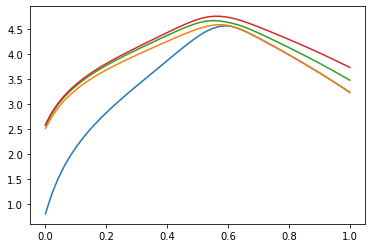

ground state energy: 3.238199693532991
1st ex state energy: 3.240785180900373
ground state eigvec: [-0.+0.j  0.+0.j -1.+0.j  0.+0.j -0.+0.j  0.+0.j  0.+0.j -0.+0.j  0.+0.j
 -0.+0.j  0.+0.j -0.+0.j  0.+0.j  0.+0.j -0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j -0.+0.j -0.+0.j  0.+0.j -0.+0.j -0.+0.j  0.+0.j -0.+0.j -0.+0.j
  0.+0.j  0.+0.j -0.+0.j  0.+0.j -0.+0.j]
1st ex state eigvec: [-0.+0.j  0.+0.j -0.+0.j -0.+0.j  0.+0.j -0.+0.j -0.+0.j  0.+0.j  0.+0.j
 -0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -0.+0.j -0.+0.j -0.+0.j -0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -0.+0.j  0.+0.j  1.+0.j
 -0.+0.j -0.+0.j -0.+0.j -0.+0.j  0.+0.j]
start gap energy (Kelvins): 961.1476030245981
min gap energy (Kelvins): 37.19392351012557
adiabatic condition (ns): 799883.8151546369


In [11]:
### from scipy.sparse.linalg import eigsh
from numpy.linalg import eigh

# plot spectrum
with open(query.instance.path, "rb") as file:
    tdse = pickle.load(file)
normalized_time = tdse.offset["normalized_time"]

num_es = 4
# unit conversion
# sol.y = [GHz / h]
make_dimensionless = 1 / energyscale * 1 / tdse.AS.B(normalized_time[1])[0]

fig = plt.figure()
ax = plt.axes()
gap = dict()

x = []
y = {es: [] for es in range(num_es)}
V = []
for s in np.linspace(normalized_time[0], normalized_time[1]):
    eigval, eigvec = eigh((tdse.annealingH(s)).toarray())
    seigval = (
        np.sort(eigval) * make_dimensionless + tdse.ising["c"] + tdse.ising["qubo_constant"]
    )
    x.append(s)
    for es in y.keys():
        y[es].append(seigval[es])
    Vi = np.einsum('ij,j->i', tdse.annealingH(s).todense(), eigvec[1])
    Vi = abs(np.einsum('i,i', eigvec[0], Vi).real)
    V.append(Vi)
for es in y.keys():
    ax.errorbar(x=x, y=y[es])
gap = {es: np.array(y[es]) - np.array(y[0]) for es in y.keys()}
plt.draw()
plt.show()
print("ground state energy:", y[0][-1])
print("1st ex state energy:", y[1][-1])
eigval, eigvec = eigh((tdse.annealingH(s)).toarray())
print("ground state eigvec:", np.round(eigvec[0]))
print("1st ex state eigvec:", np.round(eigvec[1]))
kb = 8.617333262145E-5 #eV⋅K−1
h = 4.135667696E-15 #eV⋅s
h_kb = h/kb # K*s
print("start gap energy (Kelvins):", energyscale * tdse.AS.B(normalized_time[1])[0]*(y[1][0] - y[0][0])*1E9*h_kb) 
mingap = min(np.array(y[2]) - np.array(y[0]))
print("min gap energy (Kelvins):", energyscale * tdse.AS.B(normalized_time[1])[0]*mingap*1E9*h_kb)
# calculate adiabatic condition V/gap^2
print("adiabatic condition (ns):", max(V)/mingap**2)